In the first part of this assignment, we will implement Gaussian Mixture Model and Expectation Maximization.

### **Preparation**
The following code is the preparation for importing packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans
np.random.seed(717)

### **Gaussian mixture model and Expectation maximization Implementation**

In this assignment, you should use only NumPy to build the Gaussian mixture models.

**DO NOT** use other libraries to implement the Gaussian mixture models.

**DO NOT** modify other parts of the skeleton code.

Follow the comments. They'll give you instructions on what to code.

### Step 1. Implement EM for GMM
The followings are the skeleton codes. Implement the functions inside the GMM class.

Use the pre-imported function  ```mvn(mean, cov)``` to calculate the probability density function of multivariate Gaussian distribution.

In [13]:
class GMM():
    def __init__(self, X_data, num_cluster):
        # Initialize the model parameters as the instance variable.
        self.N, self.dim = X_data.shape
        self.K = num_cluster
        self.means = np.random.random((self.K, self.dim))
        self.covariances = np.array([np.eye(self.dim)] * self.K)
        self.mixing_coefficients = np.random.random(self.K)
        self.mixing_coefficients /= self.mixing_coefficients.sum()
        self.gammas = np.zeros((self.K, self.N)) # 𝛾_𝑘(𝑛)

    # Function for computing log likelihood.
    def log_likelihood(self, X_data):
        result = 0
        ################## IMPLEMENT HERE ##################
        for i in range(self.N):
          prob = 0
          for j in range(self.K):
            prob += self.mixing_coefficients[j] * mvn(self.means[j], self.covariances[j]).pdf(X_data[i])

          result += np.log(prob)
        ####################################################
        return result

    # Function for expectation step.
    def E_step(self, X_data):
        # Compute the posterior probability.
        for i in range(self.K):
            for j in range(self.N):
                ################## IMPLEMENT HERE ##################
                # In order to adjust the parameter, Compute the posterior probability over all possibilities.
                self.gammas[i,j] = self.mixing_coefficients[i]*mvn(self.means[i], self.covariances[i]).pdf(X_data[j]) #6장 p29 식의 분자
                ####################################################
        # Normalize the posterior probability for each data point.
        self.gammas /= self.gammas.sum(0) #p29 분모로 나눔

    # Function for maximization step.
    def M_step(self, X_data):
        self.mixing_coefficients = np.zeros(self.K)
        self.means = np.zeros((self.dim, self.dim))

        # Update the mixing coefficient vector using the result of the E step.
        for i in range(self.K):
            for j in range(self.N):
                ################## IMPLEMENT HERE ##################
                self.mixing_coefficients[i] += self.gammas[i, j] #p32 pi에 해당하는 부분
                ####################################################

        ################## IMPLEMENT HERE ##################
        # Normalize the mixing coefficient.
        self.mixing_coefficients /= self.N
        ####################################################

        # Update the mean vector.
        for i in range(self.K):
            for j in range(self.N):
                ################## IMPLEMENT HERE ##################
                # Multiply the each data point by the corresponding 𝛾_𝑘(𝑛).
                self.means[i] += self.gammas[i, j]*X_data[j]
                ####################################################

            ################## IMPLEMENT HERE ##################
            # Divide by the number of data points in the i-th distribution
            self.means[i] /= self.gammas[i, :].sum()
            ####################################################

        # Update the covariance matrix.
        for i in range(self.K):
            for j in range(self.N):
                ################## IMPLEMENT HERE ##################
                # Subtract mean from the data point.
                tmp = np.reshape(X_data[j]-self.means[i], (len(self.means),1))
                # Multiply the above matrix and multiply the gamma value.
                self.covariances[i] += self.gammas[i, j] * np.dot(tmp, tmp.T)
                ####################################################
            ################## IMPLEMENT HERE ##################
            # Divide by the number of data points in the i-th distribution.
            self.covariances[i] /= self.gammas[i,:].sum()
            ####################################################


    def train(self, X_data, iterations=1000, threshold=0.001):
        ################## IMPLEMENT HERE ##################
        # Initialize the log-likelihood value to start the training.
        self.P_new = self.log_likelihood(X_data)
        self.P_old = 2*self.P_new
        ####################################################
        iteration = 0
        while((abs((self.P_old - self.P_new)/self.P_new)*100) > threshold and (iteration <= iterations)):
            ################## IMPLEMENT HERE ##################
            # Repeat the E and M step to update the parameters
            # until the difference in log-likelihood value between iterations, or total iterations end.
            self.E_step(X_data)
            self.M_step(X_data)
            self.P_old = self.P_new
            self.P_new = self.log_likelihood(X_data)
            iteration+=1
            ####################################################


In [3]:
def plot_for_EM(X_data, E, mean, mu_1, mu_2, num_1):
    # Generates the empty lists for each cluster.
    cl1, cl2 = list(), list()

    # We don't know the order of the points (due to the initialization),
    # so we make two variables (true1, true2) for count
    true1 = 0
    true2 = 0
    for i in range(len(X_data)):
        if E[i, 0] > E[i, 1]:
            cl1.append(X_data[i,:])
            if i < num_1:
                true1 += 1
            else:
                true2 += 1
        else:
            cl2.append(X_data[i,:])
            if i >= num_1:
                true1 += 1
            else:
                true2 += 1

    # Make lists into the NumPy array.
    cl1 = np.array(cl1)
    cl2 = np.array(cl2)
    index = 0 if true1 > true2 else 1
    color = ['b.', 'r.']

    # Compute the accuracy of the prediction for the EM algorithm and the center of each cluster.
    print(f'- The accuracy of the prediction for the EM algorithm : {float(max(true1, true2)) / len(X_data)}')
    print(f'- The estimated center of cluster 1 : ({mean[index,0]}, {mean[index,1]})')
    print(f'- The estimated center of cluster 2 : ({mean[1-index,0]}, {mean[1-index,1]})')

    fig = plt.figure(figsize=(9, 6), dpi=100)
    ax = fig.add_subplot(111)
    ax.scatter(cl1[:,0], cl1[:,1], label="Cluster 1")
    ax.scatter(cl2[:,0], cl2[:,1], label="Cluster 2")
    ax.plot(mean[0,0], mean[0,1], marker='*', color='black', linestyle='None',label="Estimated center")
    ax.plot(mean[1,0], mean[1,1], marker='*', color='black', linestyle='None')
    ax.plot(mu_1[0], mu_1[1], marker='+', color='black', linestyle='None', label="Original center")
    ax.plot(mu_2[0], mu_2[1], marker='+', color='black', linestyle='None')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("The scatter plot of the prediction for EM algorithm", fontsize=17)
    plt.show()

### Step 2. Load the sample dataset
Load the sample dataset and visualize it using the scatter plot.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


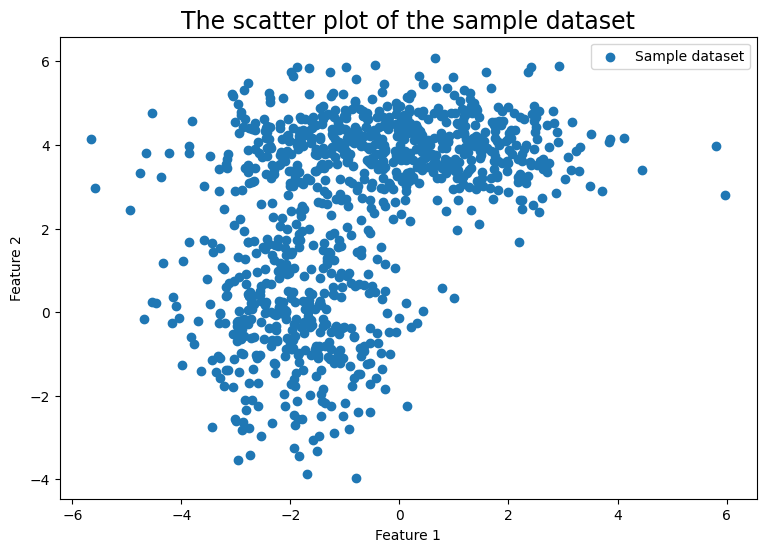

In [9]:
# The Dataset(X_data).npy is generated by the multivariate gaussian distribution.
# To compute the accuracy and visualize the prediction results,the graound truth information is provided.
mu_1 = [0, 4] # The mean vector of each group.
mu_2 = [-2, 0] # The mean vector of each group.
cluster_idx = [600, 400] # The number of samples of each group.
num_cluster = len(cluster_idx)
X_data = np.load("./drive/MyDrive/Dataset(X_data).npy")

fig = plt.figure(figsize=(9, 6), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(X_data[:,0], X_data[:,1], label="Sample dataset")
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("The scatter plot of the sample dataset", fontsize=17)
plt.show()

### Step 3. Run the EM algorithm on the sample dataset and visualize the prediction results
Initialize the GMM model with the sample data and the number of samples or each cluster. Set the total iterations and threshold to complete learning, and then run the EM algorithm

In [14]:
model = GMM(X_data, num_cluster = num_cluster)
model.train(X_data, iterations = 1000, threshold=0.001)

- The accuracy of the prediction for the EM algorithm : 0.972
- The estimated center of cluster 1 : (-0.01852956301384547, 3.9802213559423634)
- The estimated center of cluster 2 : (-1.9348792768686764, 0.015964142561783735)


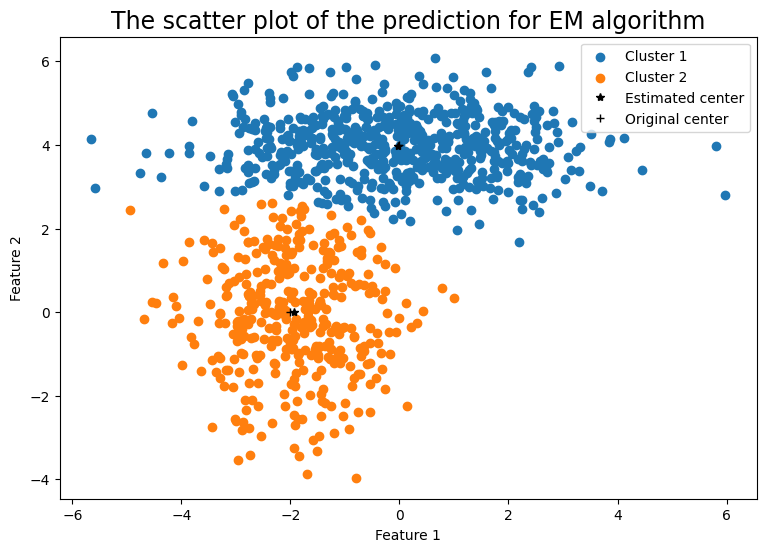

In [16]:
plot_for_EM(X_data, model.gammas.T, model.means, mu_1, mu_2, cluster_idx[0])

### Step 4.  Visualize the prediction result of the K-Means algorithm for the sample dataset
Check the difference in the predicted center coordinates between the EM algorithm and the K-Means algorithm.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


- The accuracy of the prediction for the K-Means algorithm : 0.967
- The estimated center of cluster 1 : (-0.04605809438117914, 3.943580293969495)
- The estimated center of cluster 2 : (-1.9949643101987076, -0.14160234751328193)


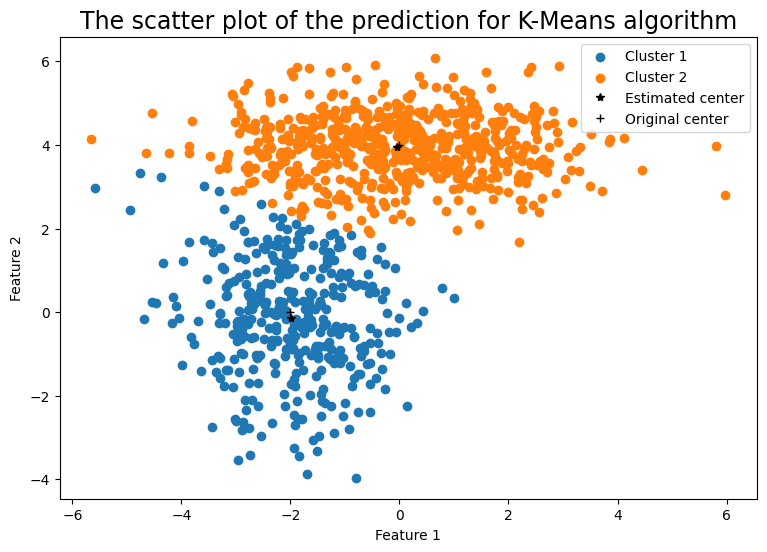

In [17]:
# Run KMean Clustering
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_data)
labels = kmeans.predict(X_data)
kmean_center = kmeans.cluster_centers_

x = X_data[:, 0]
y = X_data[:, 1]
x_1, y_1 = x[labels==0], y[labels==0]
x_2, y_2 = x[labels==1], y[labels==1]
m_1 = np.array([np.average(x_1), np.average(y_1)])
m_2 = np.array([np.average(x_2), np.average(y_2)])

# We don't know the order of the points (due to the initialization), so we check the distance between center and the mean
true = 0.0
num = cluster_idx[0]
index = 0 if np.linalg.norm(m_1 - mu_1) < np.linalg.norm(m_1 - mu_2) else 1
true += len(labels[:num][labels[:num]==index])
true += len(labels[num:][labels[num:]==1 - index])
color = ['b.', 'r.']

# Compute the accuracy of the prediction for the N-Means algorithm and the center of each cluster.
print(f'- The accuracy of the prediction for the K-Means algorithm : {true / len(X_data)}')
print(f'- The estimated center of cluster 1 : ({kmean_center[index,0]}, {kmean_center[index,1]})')
print(f'- The estimated center of cluster 2 : ({kmean_center[1-index,0]}, {kmean_center[1-index,1]})')

fig = plt.figure(figsize=(9, 6), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(x_1, y_1,label="Cluster 1")
ax.scatter(x_2, y_2, label="Cluster 2")
ax.plot(m_1[0], m_1[1], marker='*', color='black', linestyle='None',label="Estimated center")
ax.plot(m_2[0], m_2[1], marker='*', color='black', linestyle='None')
ax.plot(mu_1[0], mu_1[1], marker='+', color='black', linestyle='None', label="Original center")
ax.plot(mu_2[0], mu_2[1], marker='+', color='black', linestyle='None')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("The scatter plot of the prediction for K-Means algorithm", fontsize=17)
plt.show()